In [1]:
import pandas as pd
import requests
from fbprophet import Prophet
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
init_notebook_mode(connected=True)
from ipywidgets import interact
from ipywidgets import widgets

In [2]:
class Stocks(object):
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.df = None
        self.filename = None
        

    def get(self, stock_name):
        resp = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_name}&apikey={self.api_key}&outputsize=full')
        j = resp.json()
        self.df = pd.DataFrame(j['Time Series (Daily)']).T
        self.filename = stock_name
        return self.df
    
    
    @staticmethod
    def candle_moving(df1, filename, window, offline=False):
        moving_average = go.Scatter(x = df1[::-1].index, y = df1[::-1]['4. close'].rolling(window=window,
                                                                                           min_periods=5).mean(),
                                    name = 'moving_average', mode = 'lines', 
                                    marker = dict(color = ('rgb(255,140,0)')))

        cs = go.Candlestick(x=df1.index,
                        open=df1['1. open'],
                        high=df1['2. high'],
                        low=df1['3. low'],
                        close=df1['4. close'], name = filename)

        data = [cs, moving_average]

        layout = dict(
        title='Stocks',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(count=5,
                         label='5y',
                         step='year',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
        )

        fig = dict(data=data, layout=layout)
        if offline:
            return plot(fig, filename = filename+'.html')
        return iplot(fig, filename = filename)
    

    @staticmethod
    def candle(df1, filename, offline=False):

        cs = go.Candlestick(x=df1.index,
                        open=df1['1. open'],
                        high=df1['2. high'],
                        low=df1['3. low'],
                        close=df1['4. close'], name = filename)

        data = [cs]

        layout = dict(
        title='Stocks',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(count=5,
                         label='5y',
                         step='year',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
        )

        fig = dict(data=data, layout=layout)
        if offline:
            return plot(fig, filename = filename+'.html')
        return iplot(fig, filename = filename)
    
    
    def widget(self,window):
        if window == 5:
            Stocks.candle_moving(self.df, self.filename, 5)
        elif window == 10:
            Stocks.candle_moving(self.df, self.filename, 10)
        elif window == 20:
            Stocks.candle_moving(self.df, self.filename, 20)
        elif window == 50:
            Stocks.candle_moving(self.df, self.filename, 50)
        elif window == 100:
            Stocks.candle_moving(self.df, self.filename, 100)
        elif window == 'None':
            Stocks.candle(self.df, self.filename)
            
    
    @staticmethod
    def trace(df, df1, filename, offline=False):
        yhat = go.Scatter(x = df['ds'], y = df['yhat'],
                          mode = 'lines', line = dict(color='red'), name = 'yhat')


        yhat_lower = go.Scatter(x = df['ds'], y = df['yhat_lower'],
                                mode = 'lines', line = dict(color = ('rgb(140, 188, 250)')), name = 'yhat_lower')

        yhat_upper = go.Scatter(x = df['ds'],y = df['yhat_upper'],
                                mode = 'lines',fill = 'tonexty',
                                line = dict(color = ('rgb(140, 188, 250)')), name = 'yhat_upper')

        actual = go.Scatter(x = df1['ds'], y = df1['y'], name = 'actual',
                            mode = 'markers', marker = dict(color = ('rgb(0,0,0)'), size = 3))


        data = [yhat, yhat_lower, yhat_upper, actual]

        layout = dict(
        title='Stocks',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(count=5,
                         label='5y',
                         step='year',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
        )

        fig = dict(data=data, layout=layout)
        if offline:
            return plot(fig, filename=filename+'.html')
        return iplot(fig, filename=filename)

    
    
    def future(self):
        f_df = self.df.reset_index().rename(columns={'4. close': 'y', 'index':'ds'})[['ds', 'y']]
        f_df['y'] = f_df['y'].astype('float')

        m = Prophet()
        m.fit(f_df)
        future = m.make_future_dataframe(periods=365)
        forecast = m.predict(future)
        
        fig = m.plot_components(forecast)
        
        return Stocks.trace(forecast, f_df, filename=self.filename)

In [3]:
s = Stocks('your_api_key')

In [4]:
df = s.get(stock_name = 'hexo')

In [5]:
interact(s.widget, window = widgets.Dropdown(options=['None', 5,10,20,50,100], value = 'None',
                                          description='MA Window ', disabled=False))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

/Applications/anaconda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Applications/anaconda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



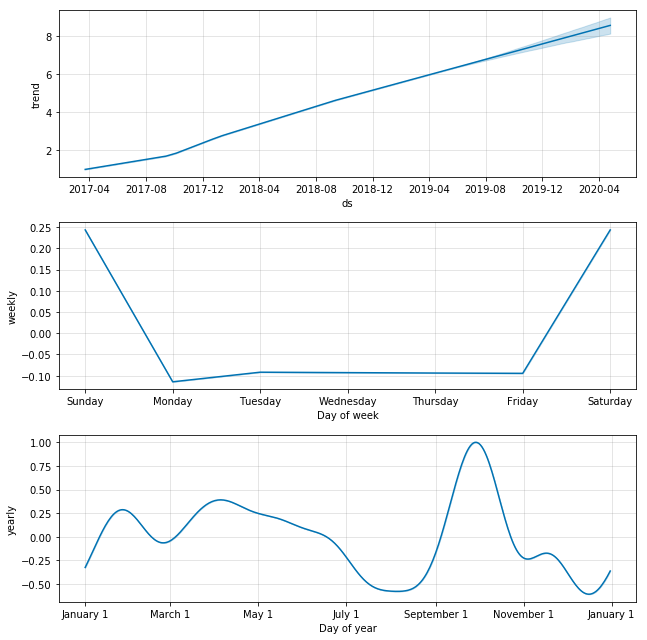

In [6]:
s.future()